# House Prices : Advances Regression Techniques

<br>

### Problématique du Challenge

Ce projet est une compétition de data science, qui consiste à prédire le prix de vente de maisons résidentielles à partir d'un ensemble de 79 variables décrivant chaque aspect des maisons à Ames, Iowa. 

Le but de la compétition est de prédire le prix de vente de chaque maison à partir de l'ensemble de données fourni. Les prédictions sont évaluées en utilisant la Root Mean Square Error (RMSE) entre le logarithme de la valeur prédite et le logarithme du prix de vente observé. 

Le jeu de données utilisé dans cette compétition, "jeu de données Ames Housing", a été créé par Dean De Cock pour une utilisation dans la Data Science. C'est une alternative élargie au célèbre jeu de données "Boston Housing".

Les données d'apprentissage sont disponibles dans le fichier "train.csv", les données à prédire sont disponibles quant à elle dans le fichier "test.csv"

Le challenge Kaggle est disponible au lien suivant :
[House Prices - Advanced Regression Techniques | Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)

<br>

### Notre approche 

Afin de prédire au mieux le prix des maisons de notre base de données test, voici l'approche que nous allons suivre tout au long de ce notebook :
- Préparation de la base de données : Séparation des données train, validation et test
- Choix et analyse des variables explicatives de notre modèle
- Modèle simple benchmark : Utilisation d'une régression linéaire pénalisée qui nous servira de benchmark pour comparer nos modèles de Machine Learning
- Modèle non supervisé : Utilisation d'un ... pour
- Modèle supervisé : Utilisation d'un ... 
- Interprétation de notre modèle à l'aide de ...
- Modèle de Deep Learning : Utilisation d'un ...
- Comparaison des modèles et interprétation des résultats

<br>

Drop NA

Drop duplicated lines

### Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Chargement des données

In [2]:
train_set = pd.read_csv("./train.csv")
test_set = pd.read_csv("./test.csv")

print(f"Notre base de donnes est composée de {train_set.shape[0]} obsevations et {train_set.shape[1]} colonnes")

Notre base de donnes est composée de 1460 obsevations et 81 colonnes


Regardons les premières observations de notre data

In [3]:
train_set.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
test_set.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Nous remarquons que la colonne "Id" est inutile dans nos données d'entraînement, nous pouvons donc la retirer de notre étude. Pour les donnée de test, nous allons remplacer l'index de notre dataframe par cette colonne *Id*.

De plus, séparons notre variable d'étude **SalePrice** de nos variables explicatives. Nous nous retrouvons alors avec 79 variables explicatives.

In [5]:
train_set.drop("Id", axis=1, inplace = True)
test_set.drop("Id", axis=1, inplace = True)

y_label = "SalePrice"
y_train = train_set[y_label]
X_train = train_set.drop(y_label, axis=1)

X_test = test_set

Enfin, divison notre échantillon d'entraînement en un train set et un validation set à l'aide de la fonction suivante :

In [6]:
def split_data(X, y, ratio):
    n = X.shape[0]
    train_index = np.random.choice(n, int(n * ratio), replace=False)
    validation_index = np.delete(np.arange(n), train_index)
    return X.iloc[train_index], y.loc[train_index], X.loc[validation_index], y.loc[validation_index]

In [7]:
X_train, y_train, X_validation, y_validation = split_data(X_train, y_train, 0.7)

Pour avoir une idée de la variable que nous cherchons à prédire, voici un histogramme du prix des maisons de notre training set

count      1021.000000
mean     179914.618022
std       79247.552016
min       34900.000000
25%      129000.000000
50%      160000.000000
75%      213000.000000
max      625000.000000
Name: SalePrice, dtype: float64


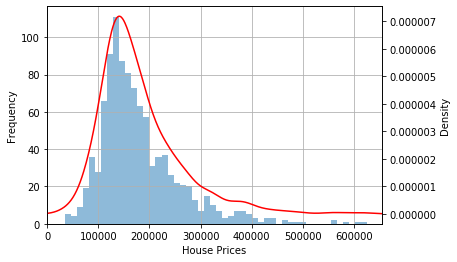

In [8]:
print(y_train.describe())
ax = y_train.hist(bins=50, alpha=0.5)
ax.set_ylabel('Frequency')
ax.set_xlabel("House Prices")
ax.set_xlim(0)
# Ajouter la courbe de densité sur un axe y secondaire
y_train.plot.density(ax=ax.twinx(), color='red')
plt.show()

Nous allons maintenant étudier les variables explicatives et sélectionner celles qui nous semblent pertinentes afin d'obtenir les meilleures prédictions. 

Commençons par avoir une vue d'ensemble sur ces variables

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021 entries, 1133 to 678
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1021 non-null   int64  
 1   MSZoning       1021 non-null   object 
 2   LotFrontage    833 non-null    float64
 3   LotArea        1021 non-null   int64  
 4   Street         1021 non-null   object 
 5   Alley          65 non-null     object 
 6   LotShape       1021 non-null   object 
 7   LandContour    1021 non-null   object 
 8   Utilities      1021 non-null   object 
 9   LotConfig      1021 non-null   object 
 10  LandSlope      1021 non-null   object 
 11  Neighborhood   1021 non-null   object 
 12  Condition1     1021 non-null   object 
 13  Condition2     1021 non-null   object 
 14  BldgType       1021 non-null   object 
 15  HouseStyle     1021 non-null   object 
 16  OverallQual    1021 non-null   int64  
 17  OverallCond    1021 non-null   int64  
 18  YearBu

Vous pouvez obtenir plus d'informations sur chacune des variables explicatives dans le document *data_description.txt*

Etant donné le problème de régression, nous allons uniquement conserver les variables numériques

In [10]:
X_train = X_train.select_dtypes(include=['int', 'float'])
X_validation = X_validation.select_dtypes(include=['int', 'float'])
X_test = X_test.select_dtypes(include=['int', 'float'])

Etudions maintenant les caractéristiques de chacune de ces variables et sélectionnons celles qui nous paraissent le plus pertinentes

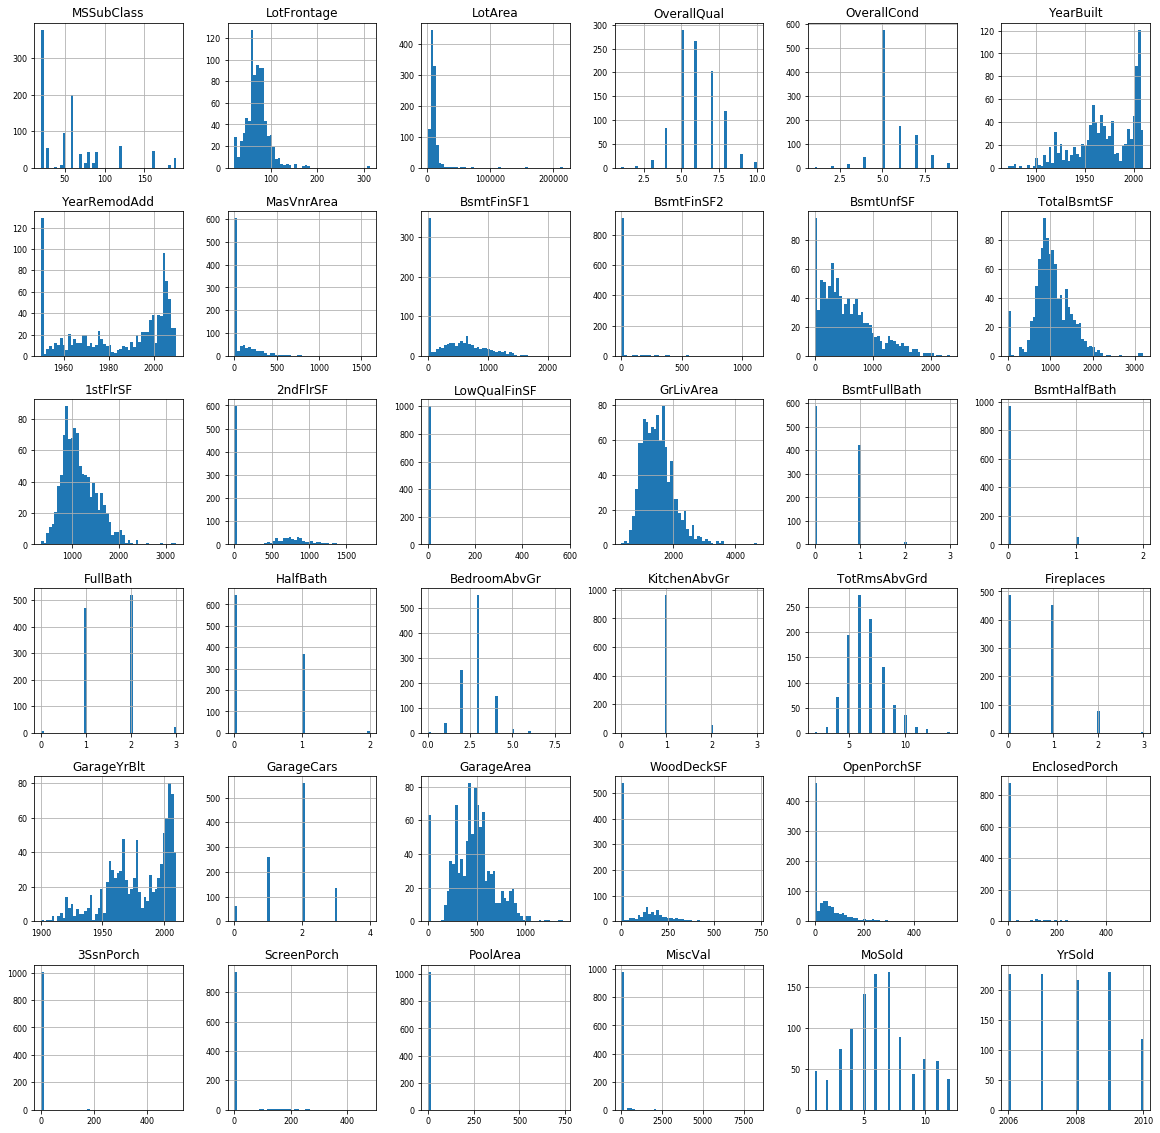

In [11]:
X_train.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8)
plt.show()

In [12]:
X_train.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')

Voilà les colonnes numériques qui nous ont semblé pertinentes

In [13]:
interesting_num_columns = ["LotArea", "YearBuilt", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "GrLivArea", "FullBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces", "GarageArea", "PoolArea"]
X_train = X_train[interesting_num_columns]
X_test = X_test[interesting_num_columns]
X_validation = X_validation[interesting_num_columns]

Statistiques descriptives !!!